In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import odeint

import lmfit

from tqdm import tqdm
tqdm.pandas()

from pathlib import Path

import sys
sys.path.insert(0, os.path.abspath('../src'))

from plots import *
from utils import *
from sird import *

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, dpc_province_df, pop_prov_df, prov_list_df = load_data(data_path)

In [5]:
province = 'Firenze'

sirsol = sird(province, pop_prov_df)
S, I, R, D = sirsol

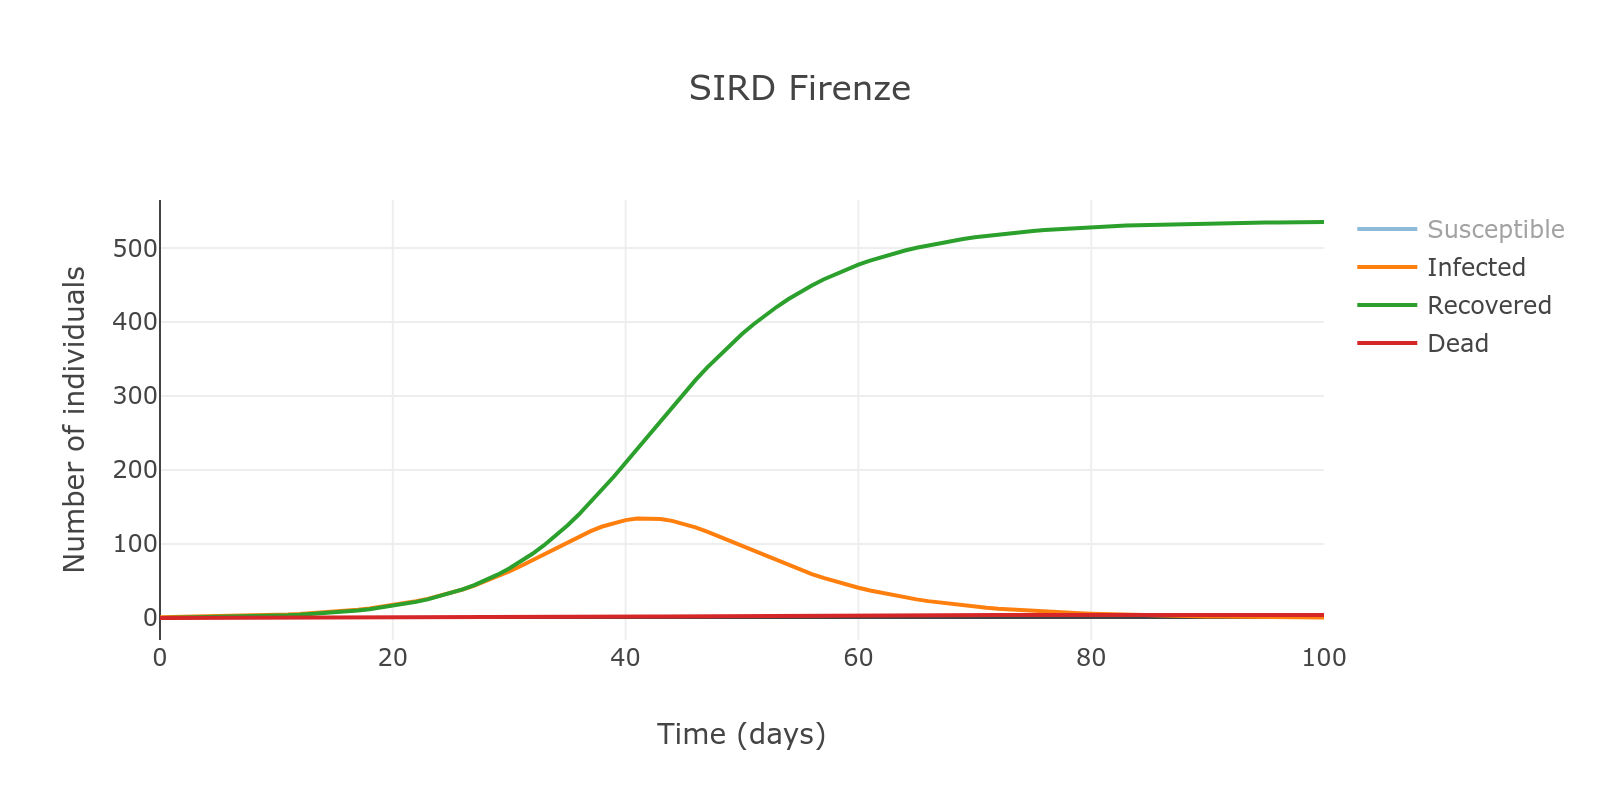

In [6]:
times = list(range(sirsol.shape[1]))

general_plot(t=times, 
             data=sirsol, 
             title='SIRD ' + province,
             traces_visibility=['legendonly'] + [True]*3,
             output_image=True)

In [7]:
#result = pd.DataFrame()
#for prov in covidpro_df.Province.unique():
#    S, I, R, D = sird(prov, pop_prov_df)
#    tmp = pd.DataFrame(np.column_stack([[prov]*len(S),range(len(S)),S,I,R,D]))
#    result = pd.concat([result, tmp])
#    
#result.columns = ["Province", "t", "S", "I", "R", "D"]
#result.reset_index(drop=True,inplace=True)

In [8]:
#inter_dropdown_plot(options=result.Province.unique(), 
#                    default_value='Firenze', 
#                    dropdown_label='Province',
#                    y=["S", "I", "R", "D"],
#                    legend_titles=['Susceptible', 'Infected', 'Recovered', 'Dead'],
#                    data=result,
#                    group_column='Province',
#                    x='t',
#                    title='COVID-19 trendlines of ',
#                    xtitle='Data',
#                    ytitle='Unità',
#                    traces_visibility=['legendonly',True,True,True],
#                    output_image=False)

In [9]:
mapping = {
    'New_cases': 2,
    'Curr_pos_cases': 2,
    'Tot_deaths': 4,
    'Deaths': ('Deaths', D),
    'Infected': ('New_cases', I)
}

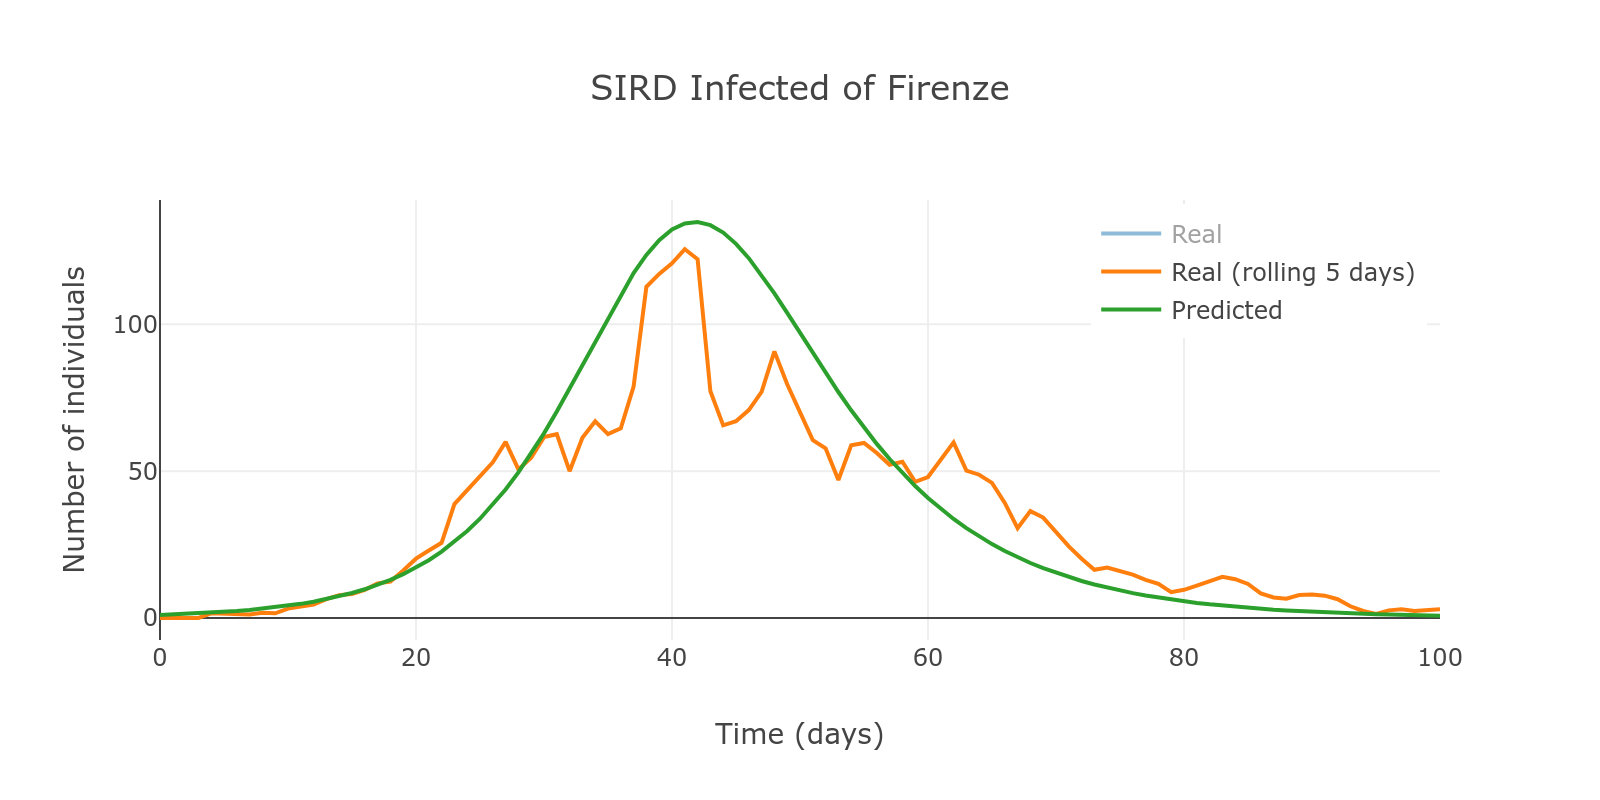

In [10]:
names, title, data, modes = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

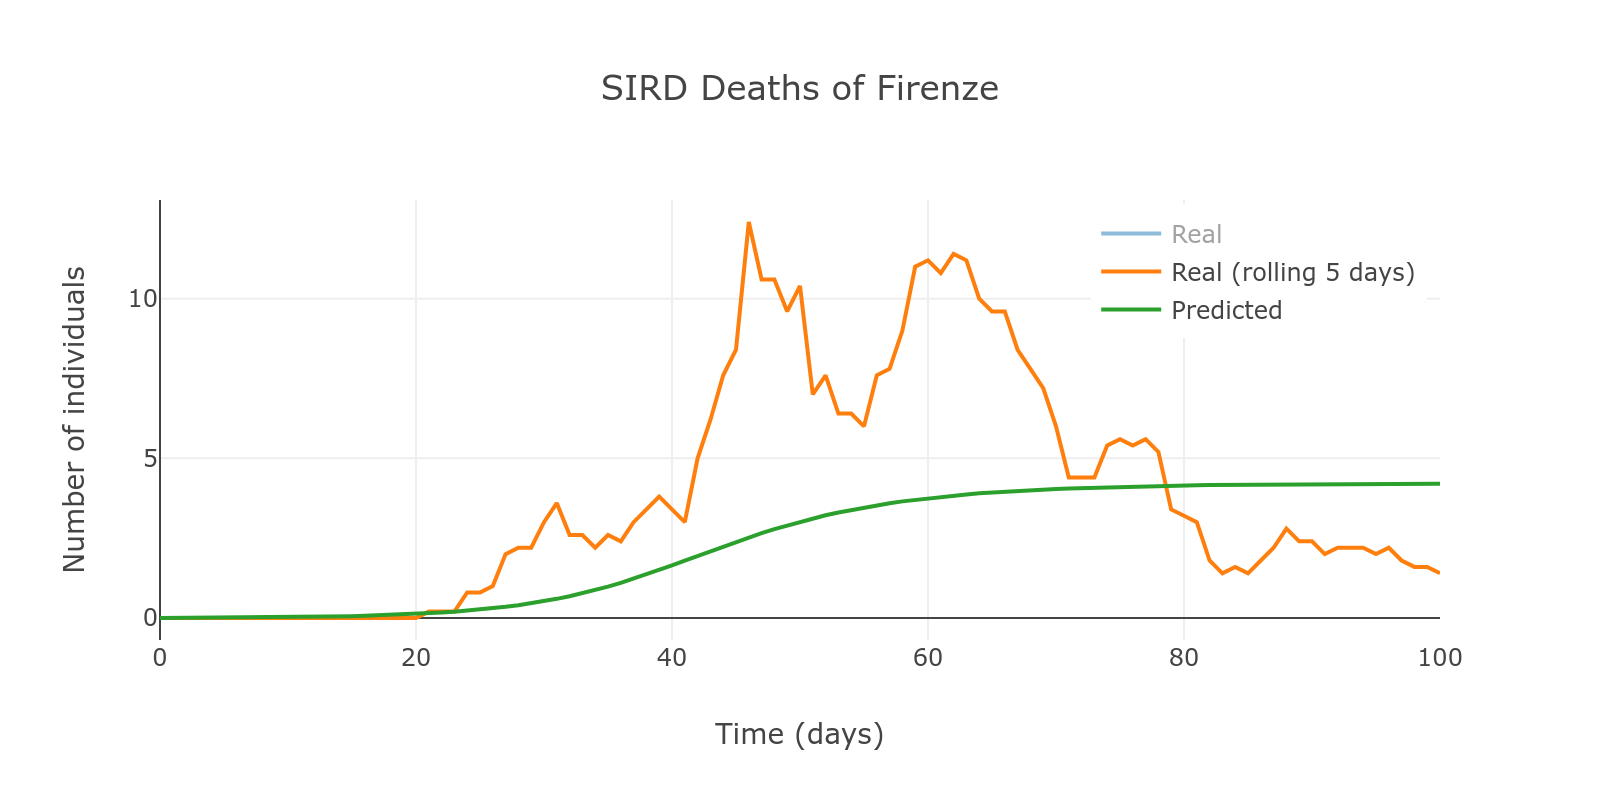

In [11]:
names, title, data, modes = data_for_plot('Deaths', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data, 
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [12]:
result = pd.DataFrame()
for prov in covidpro_df.Province.unique():
    _, I, _, _ = sird(prov, pop_prov_df)
    names, _, data, _ = data_for_plot('Infected', covidpro_df, mapping, prov)
    tmp = pd.DataFrame(np.column_stack([[prov]*data[2].shape[0],range(data[2].shape[0]),data[0],data[1],data[2]]))
    result = pd.concat([result, tmp])
    
result.columns = ["Province", "t", "real", "real_roll", "pred"]
result.reset_index(drop=True,inplace=True)

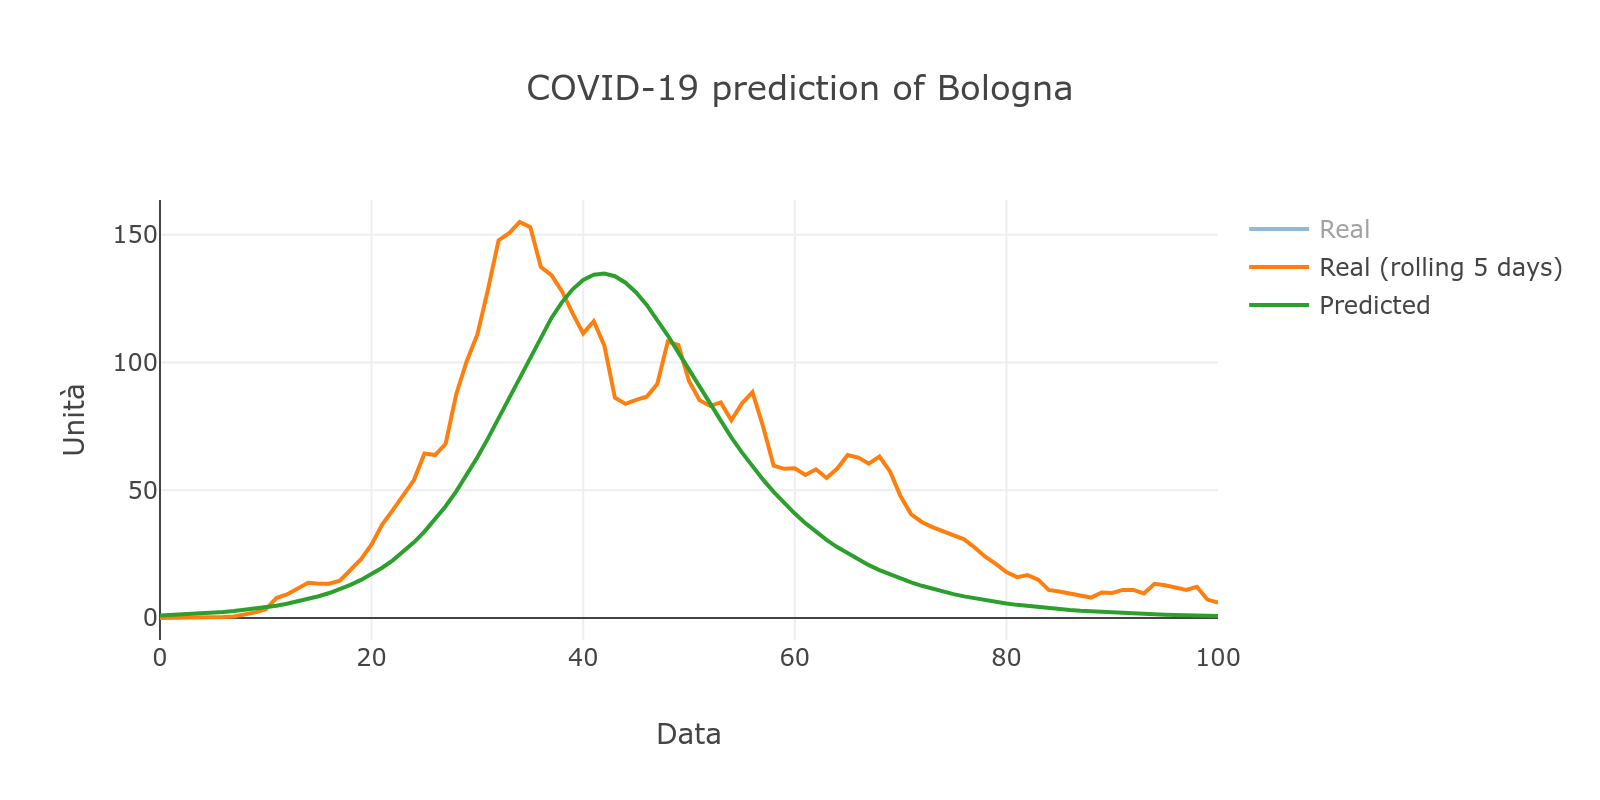

In [13]:
inter_dropdown_plot(options=result.Province.unique(), 
                    default_value='Bologna', 
                    dropdown_label='Province',
                    y=["real", "real_roll", "pred"],
                    legend_titles=names,
                    data=result,
                    group_column='Province',
                    x='t',
                    title='COVID-19 prediction of ',
                    xtitle='Data',
                    ytitle='Unità',
                    output_image=True,
                    traces_visibility=['legendonly',True,True])

In [14]:
mapping['Deaths'] = 4

In [15]:
def fitter(x, R_0_start, k, x0, R_0_end):
    # x=2 for I; x=4 for D
    ret = Model(days, N, R_0_start, k, x0, R_0_end)
    return ret[mapping[compart]][x]

In [16]:
def get_model(province, compart, data_df, pop_df, query='20200603 > Date'):
    data = data_df[data_df.Province == province].query(query)[compart]
    if compart in ['New_cases', 'Deaths']:
        data = data.rolling(window=5).mean().fillna(0)
    
    N = pop_df.loc[(pop_df.Territorio == province) & (pop_df.Eta == "Total")]['Value'].values[0]

    # Day at which the curve starts to increase
    outbreak_shift = 20

    # {parameter: (initial guess, min value, max value)}
    params_init_min_max = {
        "R_0_start": (3.0, 1.0, 6),
        "k": (0.3, 0.01, 5.0),
        "x0": (20, 0, 100),
        "R_0_end": (0.9, 0.1, 3.5)
    }

    days = outbreak_shift + len(data)

    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    # [0, 1, ..., days]
    x_data = np.linspace(0, days-1, days, dtype=int)

    mod = lmfit.Model(fitter)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()

    return mod, params, y_data, x_data, days, N

In [17]:
province = 'Firenze'
compart = 'Curr_pos_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df)

In [18]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [19]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 120
    # variables        = 4
    chi-square         = 190498.384
    reduced chi-square = 1642.22745
    Akaike info crit   = 892.388870
    Bayesian info crit = 903.538837
[[Variables]]
    R_0_start:  1.96442235 +/- 0.00799240 (0.41%) (init = 3)
    k:          0.11107726 +/- 0.00370475 (3.34%) (init = 0.3)
    x0:         57.1922041 +/- 0.42139861 (0.74%) (init = 20)
    R_0_end:    1.02786142 +/- 0.00207262 (0.20%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, x0)      = -0.981
    C(R_0_start, k)       = -0.936
    C(k, x0)              =  0.861
    C(k, R_0_end)         =  0.810
    C(R_0_start, R_0_end) = -0.631
    C(x0, R_0_end)        =  0.470


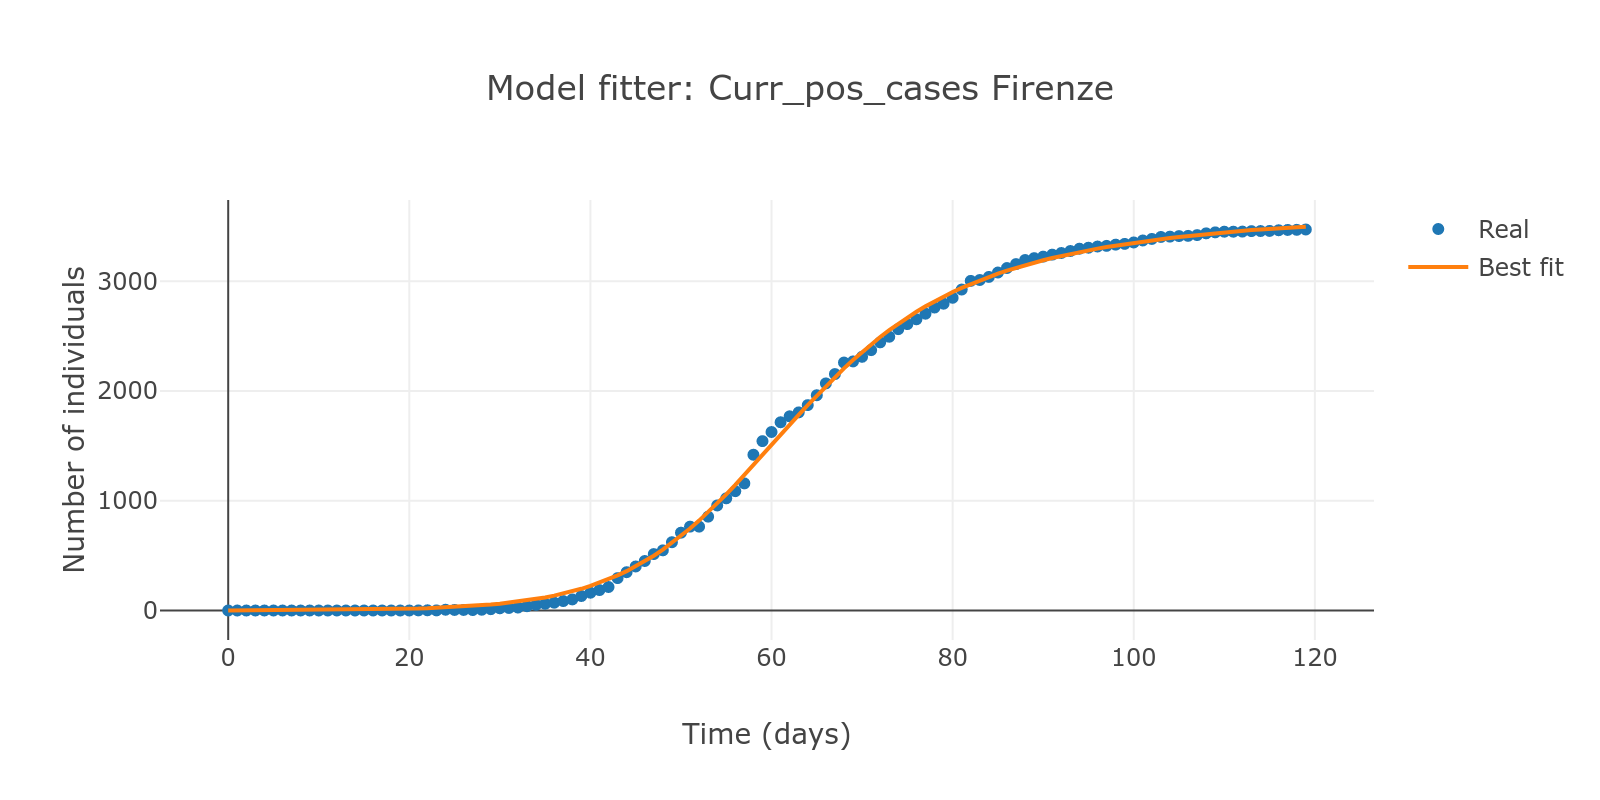

In [20]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [21]:
result.best_values

{'R_0_start': 1.9644223517994095,
 'k': 0.1110772564470416,
 'x0': 57.192204076935504,
 'R_0_end': 1.0278614225286997}

In [22]:
province = 'Firenze'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df)

In [23]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [24]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 217
    # data points      = 120
    # variables        = 4
    chi-square         = 8550.08372
    reduced chi-square = 73.7076183
    Akaike info crit   = 519.944553
    Bayesian info crit = 531.094520
[[Variables]]
    R_0_start:  1.54266479 +/- 0.00408239 (0.26%) (init = 3)
    k:          4.99999285 +/- 25.9727640 (519.46%) (init = 0.3)
    x0:         59.8303949 +/- 0.39358195 (0.66%) (init = 20)
    R_0_end:    0.65142216 +/- 0.01777314 (2.73%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, x0) = -0.685
    C(x0, R_0_end)   = -0.533
    C(k, R_0_end)    =  0.296
    C(R_0_start, k)  = -0.177
    C(k, x0)         = -0.112


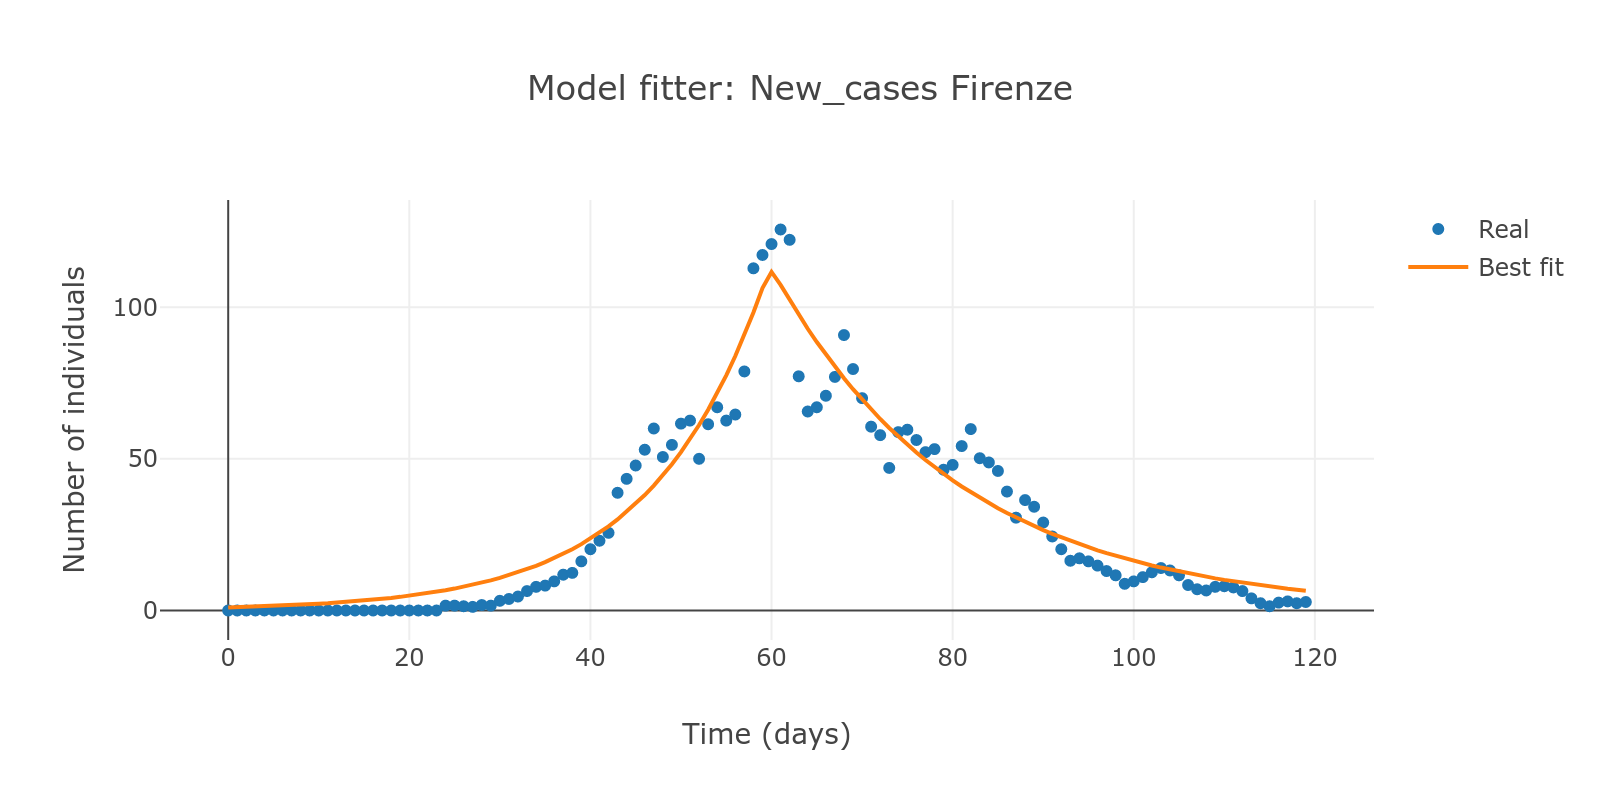

In [25]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [26]:
result.best_values

{'R_0_start': 1.5426647940004736,
 'k': 4.999992852325873,
 'x0': 59.8303949380131,
 'R_0_end': 0.6514221612236823}

In [27]:
province = 'Firenze'

sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

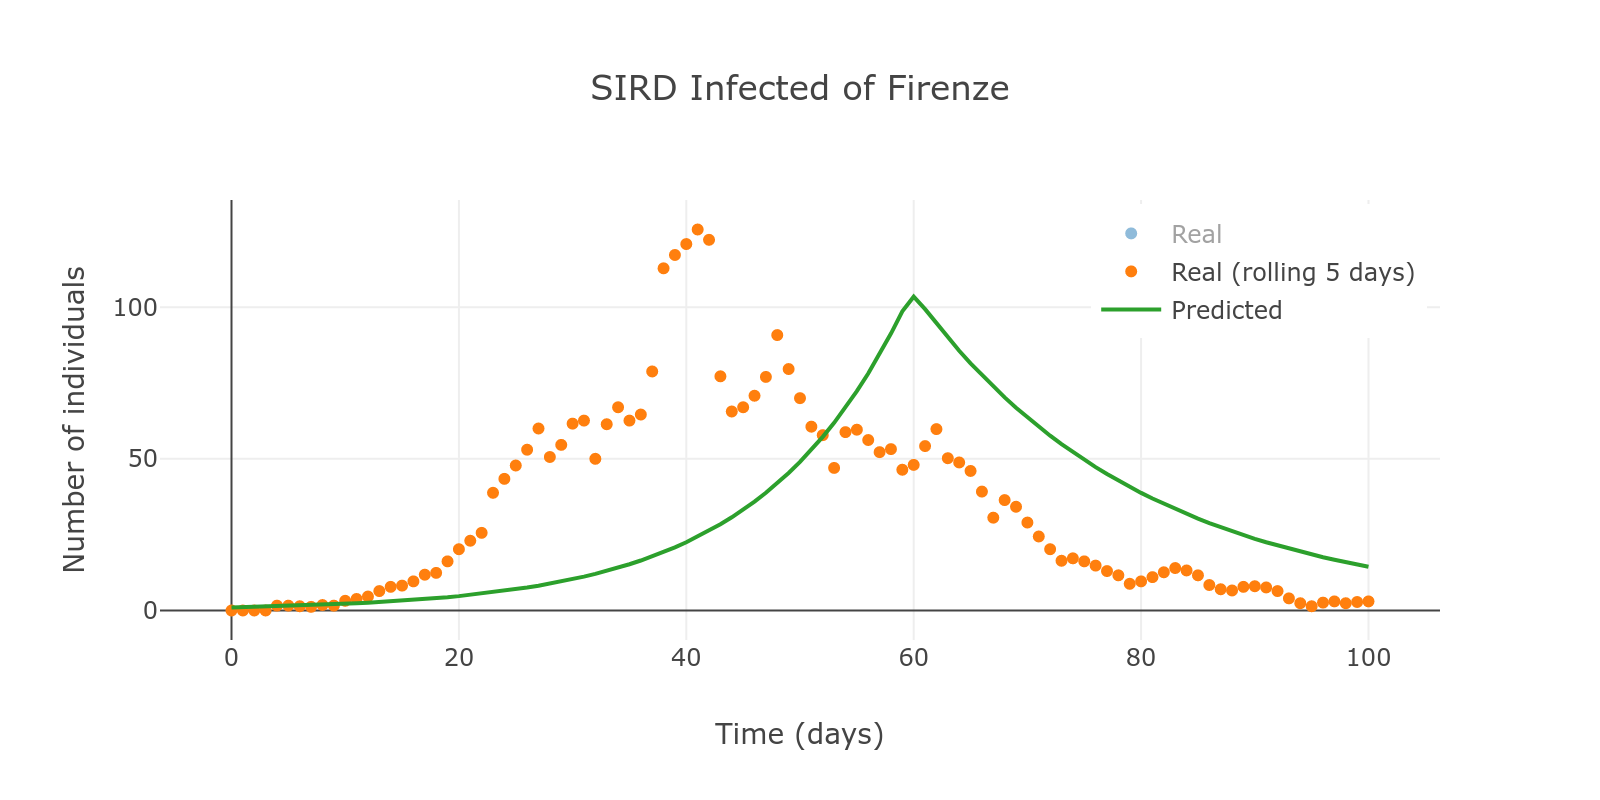

In [28]:
mapping = {
    'New_cases': 2,
    'Curr_pos_cases': 2,
    'Tot_deaths': 4,
    'Deaths': ('Deaths', D),
    'Infected': ('New_cases', I)
}

names, title, data, _ = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [29]:
province = 'Bologna'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart, covidpro_df, pop_prov_df)

result = mod.fit(y_data, params, method="leastsq", x=x_data)

lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 184
    # data points      = 120
    # variables        = 4
    chi-square         = 10881.1593
    reduced chi-square = 93.8030974
    Akaike info crit   = 548.875559
    Bayesian info crit = 560.025526
[[Variables]]
    R_0_start:  1.64217348 +/- 0.00416532 (0.25%) (init = 3)
    k:          4.99999999 +/- 0.43604687 (8.72%) (init = 0.3)
    x0:         53.8316619 +/- 0.31934278 (0.59%) (init = 20)
    R_0_end:    0.73235543 +/- 0.01017534 (1.39%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, x0) = -0.763
    C(x0, R_0_end)   = -0.478
    C(R_0_start, k)  =  0.195
    C(k, R_0_end)    = -0.185


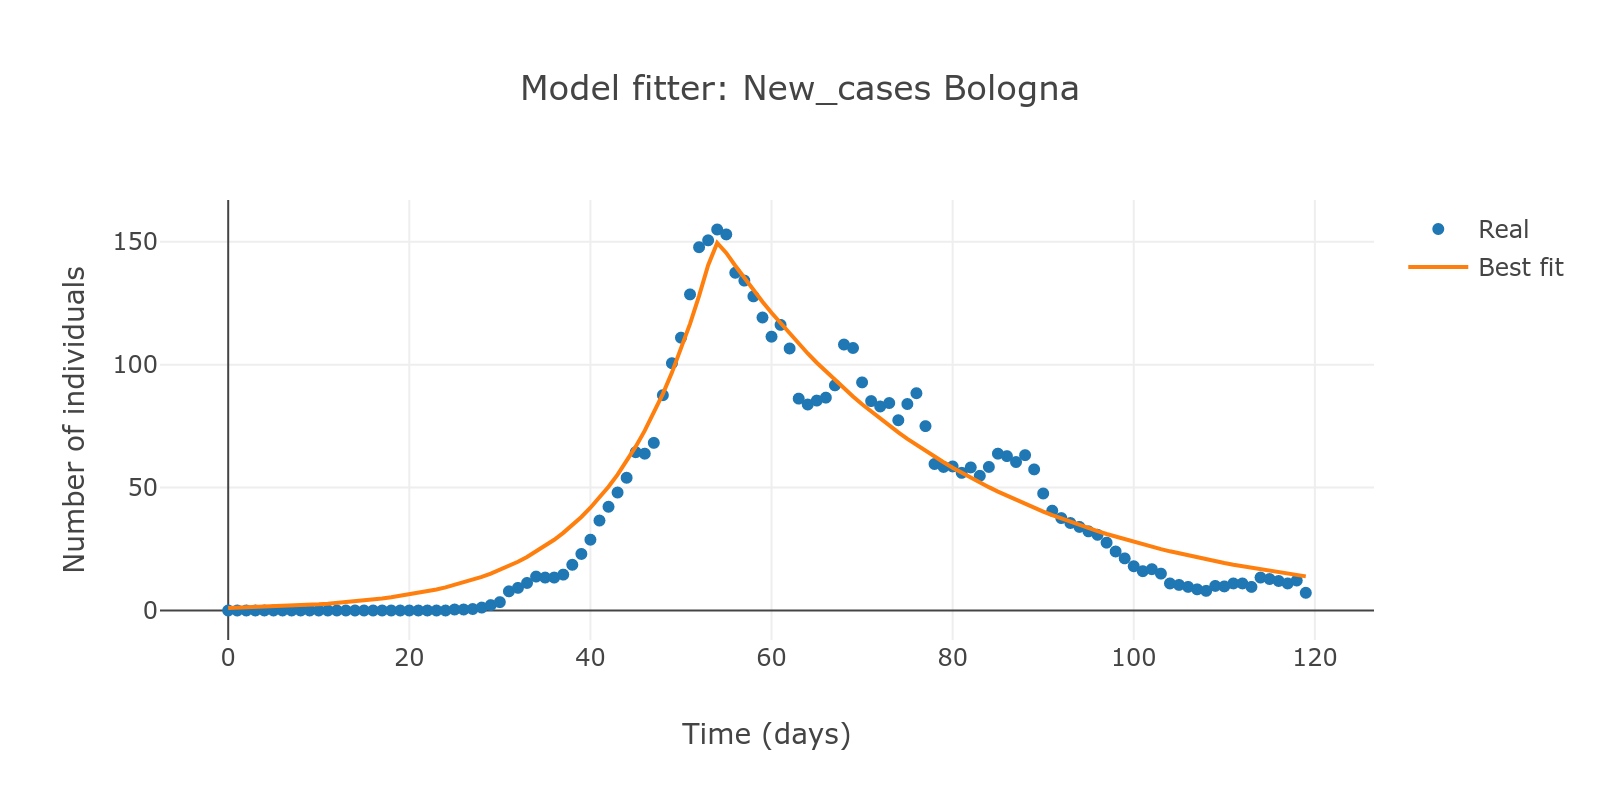

In [30]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

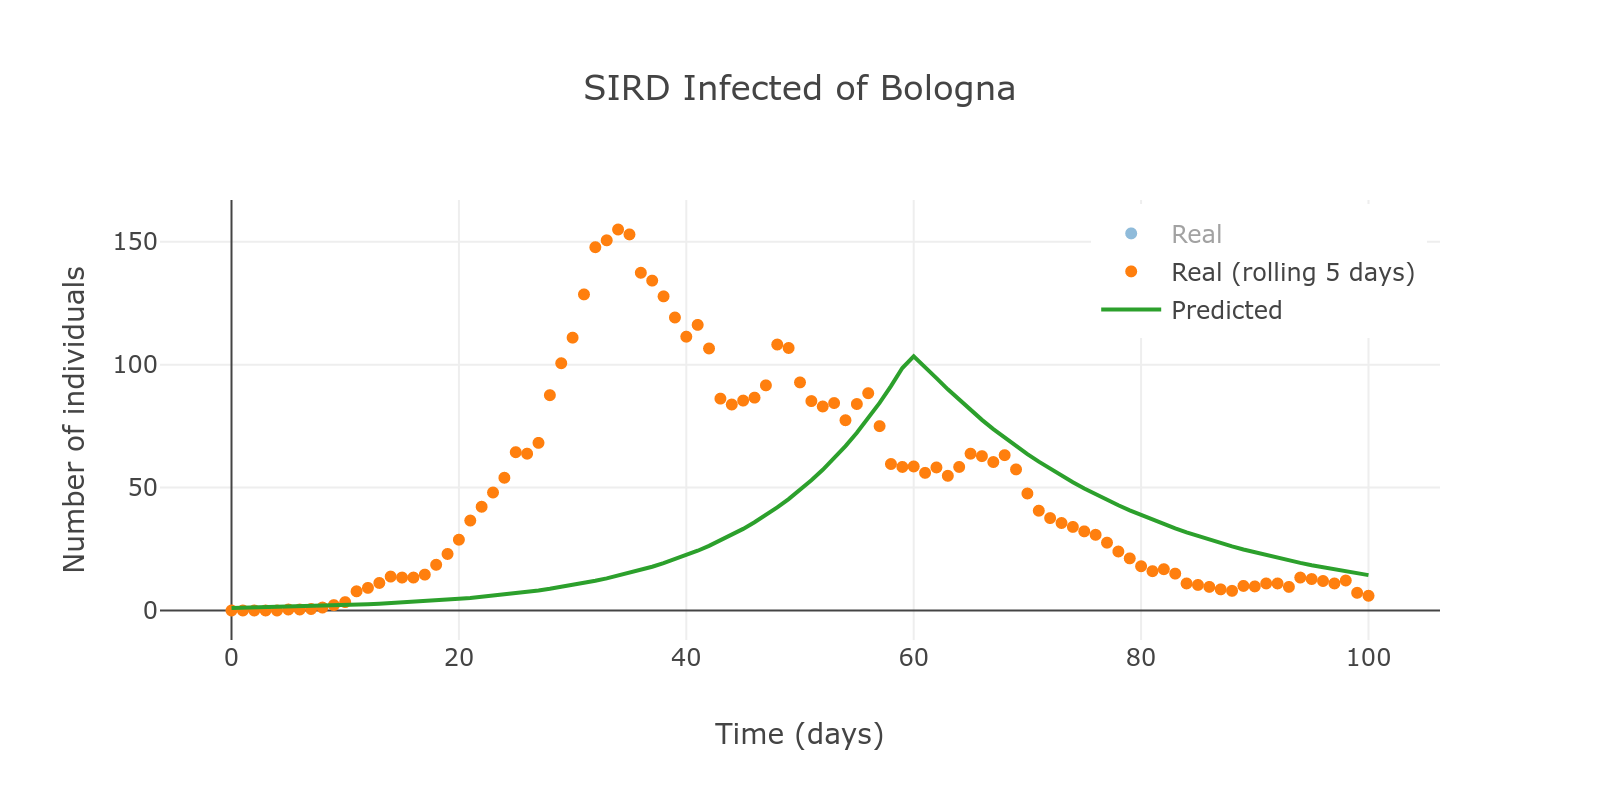

In [31]:
sirsol = sird(province, pop_prov_df, **result.best_values)
S, I, R, D = sirsol

names, title, data, _ = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=['markers', 'markers', 'lines'],
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

## Variant
Compute parameters and then predict new days

In [ ]:
regione = 'Piemonte'
pop = get_region_pop(regione, pop_prov_df, prov_list_df)

filtered_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == regione][['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi', 'nuovi_positivi']]

filtered_df['susceptible'] = pop - filtered_df['totale_casi']

filtered_df = filtered_df[['totale_positivi', 'dimessi_guariti', 'deceduti', 'susceptible', 'nuovi_positivi']]

filtered_df.columns = ['cases', 'recovered', 'deaths', 'susceptible', 'new_cases']

In [ ]:
n = filtered_df.shape[0]

recovery = np.diff(filtered_df['recovered'].values)/filtered_df.iloc[:n-1]['cases'].values
death_rate = np.diff(filtered_df['deaths'].values)/filtered_df.iloc[:n-1]['cases'].values
transm = (pop/filtered_df.iloc[:n-1]['susceptible'].values)*(np.diff(filtered_df['cases'].values)+np.diff(filtered_df['recovered'].values)+np.diff(filtered_df['deaths'].values))/filtered_df.iloc[:n-1]['cases'].values
R0 = transm/(recovery+death_rate)

In [ ]:
def fix_arr(arr):
    arr[arr < 0] = 0
    arr[np.isinf(arr)] = 0
    return np.nan_to_num(arr)

recovery = fix_arr(recovery)
death_rate = fix_arr(death_rate)
transm = fix_arr(transm)
R0 = fix_arr(R0)

In [ ]:
def compute_data(data, lag, all=False):
    N = len(data)
    x_preds = np.empty(shape=(N-lag, lag+1))

    for i in range(lag, N):
        x = [data[i-j] for j in range(lag+1)]
        x_preds[i-lag,] = x
    
    if not all:
        return x_preds[-1,1:]
    else:
        y = x_preds[:,0]
        x_preds = x_preds[:,1:]
        
        return x_preds, y

In [ ]:
from sklearn.linear_model import LinearRegression

lag = 5
reg_transm = LinearRegression().fit(*compute_data(transm, lag, True))
reg_recovery = LinearRegression().fit(*compute_data(recovery, lag, True))
reg_death = LinearRegression().fit(*compute_data(death_rate, lag, True))

In [ ]:
days_to_predict = 7

for i in range(n,days_to_predict):
    new_beta = fix_arr(reg_transm.predict(compute_data(transm, lag).reshape(1, -1)))
    new_recov = fix_arr(reg_recovery.predict(compute_data(recovery, lag).reshape(1, -1)))
    new_death = fix_arr(reg_death.predict(compute_data(death_rate, lag).reshape(1, -1)))

    new_I = np.round((1 + new_beta * (filtered_df.iloc[i]['susceptible']/pop) - new_recov - new_death)*filtered_df.iloc[i]['cases'])
    new_R = np.round(filtered_df.iloc[i]['recovered'] + new_recov * filtered_df.iloc[i]['cases'])
    new_D = np.round(filtered_df.iloc[i]['deaths'] + new_death * filtered_df.iloc[i]['cases'])

    transm.resize((transm.shape[0]+days_to_predict,), refcheck=False)
    recovery.resize((recovery.shape[0]+days_to_predict,), refcheck=False)
    death_rate.resize((death_rate.shape[0]+days_to_predict,), refcheck=False)

    transm[i] = new_beta
    recovery[i] = new_recov
    death_rate[i] = new_death

    filtered_df = filtered_df.append(pd.DataFrame(np.column_stack([new_I[0], new_R[0], new_D[0], (pop-new_I[0]-new_R[0]-new_D[0]), 0]), columns = ['cases', 'recovered', 'deaths', 'susceptible', 'new_cases']))


filtered_df['new_cases'] = [0]+list(np.diff(filtered_df['cases'].values)+np.diff(filtered_df['recovered'].values)+np.diff(filtered_df['deaths'].values))

filtered_df['new_cases'] = filtered_df['new_cases'].apply(lambda x: 0 if x < 0 else x)

filtered_df['Beta'] = list(transm) + [0]
filtered_df['Recovery Rate'] = list(recovery) + [0]
filtered_df['Death Rate'] = list(death_rate) + [0]
filtered_df['R0'] = list(transm/(recovery+death_rate)) + [0]